# Visualising Weekly Covid Deaths by Clusters of Regions
* Weekly Covid deaths for Poland are available only till mid-October 2020; data sourced from Martin's packages
* Clusters of regions bassed on two schemes; both schemes are based out of Czekanowski's diagram based on a composite distance measure, in turn based on dissimilarities between population __and__ population density between two regions (section 7.5 in the Clustering notebook)

* Scheme 1 uses clusters as originally proposed; Scheme 2 incorporates Krzysztof's feedback -- details below

* One of the reasons Scheme 1 is still in existence because 'n_class = 6' was provided to RMaCzek::czek_matrix as an argument; but if Scheme 2 is still preferred, Scheme 1 can be ignored or removed easily

<img src="output/img/clustering_czekanovski_R/chosen.png" style="width: 500px;"/>

##### Cluster Members: Scheme 1
* Cluster 1: SE214, SE322, SE221, SE212, SE213, SE321, SE332, SE331, SE312, SE311, SE313, SE124, SE122, SE125, CZ041, SE231, SE211, SE121 - 18 members
* Cluster 2: SE123, CZ051, CZ063, CZ053, CZ052, CZ032, CZ031, CZ072, CZ071 - 9 members
* Cluster 3: CZ042, PL52, PL43, PL84, CZ064, PL72, CZ080, CZ020, SE224, PL62, PL42, SE232 - 12 members
* Cluster 4: PL61, PL82, PL81, PL63, PL71, SE110 - 6 members
* Cluster 5: PL51, PL21, PL41, PL22, PL9 - 5 members
* Cluster 6: CZ010 - Singleton

##### Cluster Members: Scheme 2
* Cluster 1: SE214, SE322, SE221, SE212, SE213, SE321, SE332, SE331, SE312, SE311, SE313, SE124, SE122, SE125, CZ041, SE231, SE211, SE121, SE123, CZ051, CZ063, CZ053, CZ052, CZ032, CZ031, CZ072, CZ071 - 27 members
* Cluster 2: CZ042, PL52, PL43, PL84, CZ064, PL72, CZ080, CZ020, SE224, PL62, PL42, SE232 - 12 members
* Cluster 3: PL61, PL82, PL81, PL63, PL71, SE110 - 6 members
* Cluster 4: PL51, PL21, PL41, PL22, PL9 - 5 members
* Cluster 5: CZ010 - Singleton

### 1. Basic Data Prep

* Covid Death data fetched from Martin's packages and aggregated at weekly and regional levels
* Deaths data cross-referenced with regions / clustering information for visualisation of deaths by cluster

In [1]:
import covid19czechia as CZ
import covid19sweden as SE
import covid19poland as PL
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# download main datasets
cz_deaths = CZ.covid_deaths(level = 2)
se_deaths = SE.covid_deaths()
pl_deaths = PL.covid_deaths(level = 2)
regions = pd.read_csv("./data/regions.csv")

In [3]:
# utility function
def week_num_to_date(year, week_num):
    if year == 2020:
        return(datetime.strptime(str(year) + str(week_num) + '-1', "%Y%W-%w") - timedelta(days = 7))
    elif year == 2021:
        return(datetime.strptime(str(year) + str(week_num) + '-1', "%Y%W-%w"))

In [4]:
# aggregate data - CZ
cz_deaths['year'] = cz_deaths['date'].apply(lambda x: x.year)
cz_deaths.loc[(cz_deaths['week'] == 53) & (cz_deaths['date'].apply(lambda x:x.month) == 1), 'year'] -= 1
cz_deaths = cz_deaths.groupby(['year', 'week', 'region']).aggregate({'deaths': 'sum'}).reset_index()
cz_deaths['date'] = cz_deaths.apply(lambda r: week_num_to_date(r.year, r.week), axis = 1)

# aggregate data - PL
pl_deaths['year'] = pl_deaths['date'].apply(lambda x: x.year)
pl_deaths.loc[(pl_deaths['week'] == 53) & (pl_deaths['date'].apply(lambda x:x.month) == 1), 'year'] -= 1
pl_deaths = pl_deaths.groupby(['year', 'week', 'NUTS2']).aggregate({'deaths': 'sum'}).reset_index()
pl_deaths['date'] = pl_deaths.apply(lambda r: week_num_to_date(r.year, r.week), axis = 1)
pl_9 = pl_deaths[pl_deaths['NUTS2'].isin(['PL91', 'PL92'])] \
    .groupby(['year','week','date']).aggregate({'deaths':'sum'}).reset_index()
pl_deaths = pd.concat([pl_9, pl_deaths[~pl_deaths['NUTS2'].isin(['PL91', 'PL92'])]]) \
    .rename(columns = {'NUTS2':'region'})

# aggregate data - SE
se_deaths = se_deaths.groupby(['year', 'week', 'region']).aggregate({'deaths': 'sum'}).reset_index()
se_deaths['date'] = se_deaths.apply(lambda r: week_num_to_date(r.year, r.week), axis = 1)

# aggregate (concatenate) all countries data into one dataframe
deaths_data = pd.concat([cz_deaths, pl_deaths, se_deaths])

In [5]:
# add on cluster info to regions dataset + rename 'NUTS3' column as 'region'
regions.loc[regions['NUTS3'].isin(['SE214', 'SE322', 'SE221', 'SE212', 'SE213', 'SE321', \
                                   'SE332', 'SE331', 'SE312', 'SE311', 'SE313', 'SE124', \
                                   'SE122', 'SE125', 'CZ041', 'SE231', 'SE211', 'SE121']), 'cluster_1'] = 1

regions.loc[regions['NUTS3'].isin(['SE123', 'CZ051', 'CZ063', 'CZ053', 'CZ052', 'CZ032', \
                                   'CZ031', 'CZ072', 'CZ071']), 'cluster_1'] = 2

regions.loc[regions['NUTS3'].isin(['CZ042', 'PL52', 'PL43', 'PL84', 'CZ064', 'PL72', \
                                   'CZ080', 'CZ020', 'SE224', 'PL62', 'PL42', 'SE232']), 'cluster_1'] = 3

regions.loc[regions['NUTS3'].isin(['PL61', 'PL82', 'PL81', 'PL63', 'PL71', 'SE110']), 'cluster_1'] = 4

regions.loc[regions['NUTS3'].isin(['PL51', 'PL21', 'PL41', 'PL22', 'PL9']), 'cluster_1'] = 5

regions.loc[regions['NUTS3'] == 'CZ010', 'cluster_1'] = 6

regions['cluster_2'] = regions['cluster_1'] - 1
regions.loc[regions['cluster_2'] == 0, 'cluster_2'] = 1

regions = regions.rename(columns = {'NUTS3':'region'})

### 2. Granular Trends (by region within cluster)

In [6]:
# cross-reference regions and death data
weekly_deaths_by_region = pd.merge(regions, deaths_data, on="region", how="left")

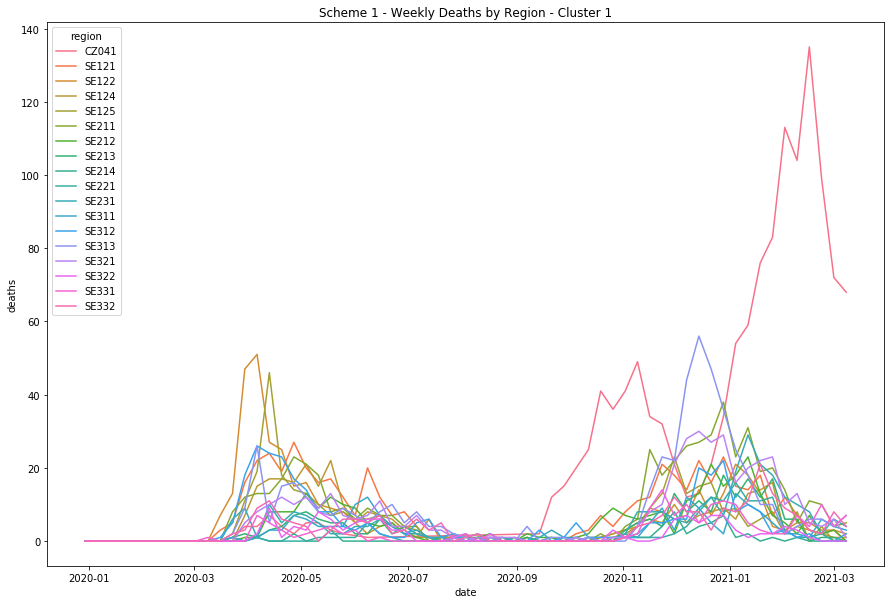

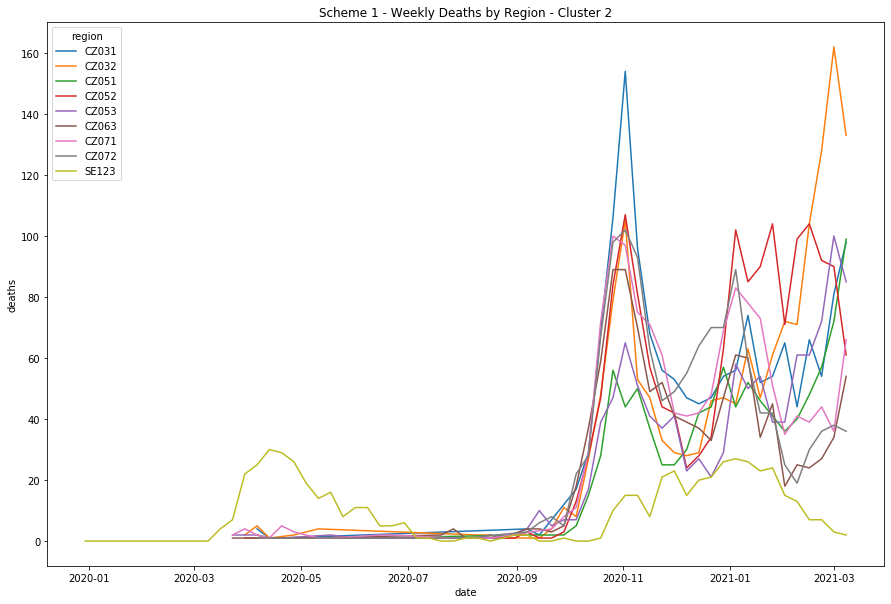

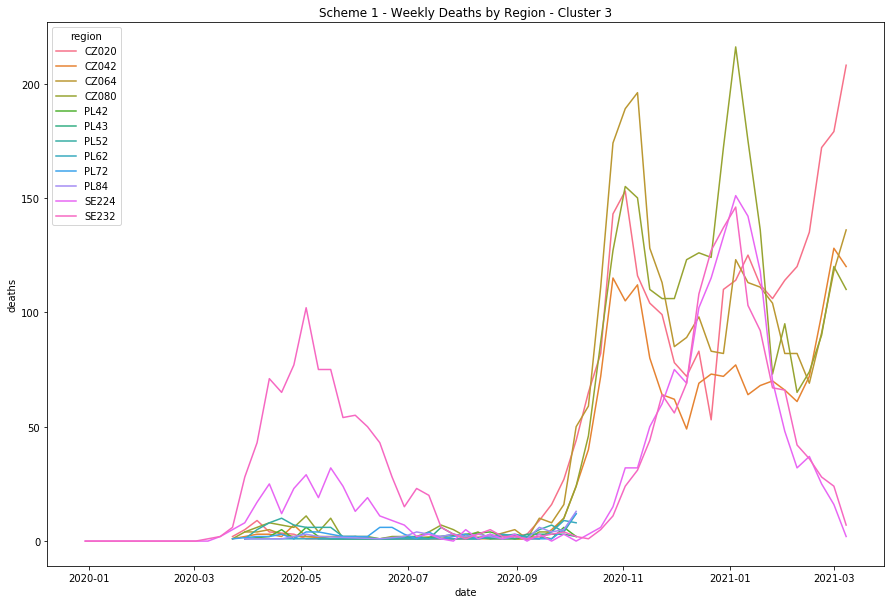

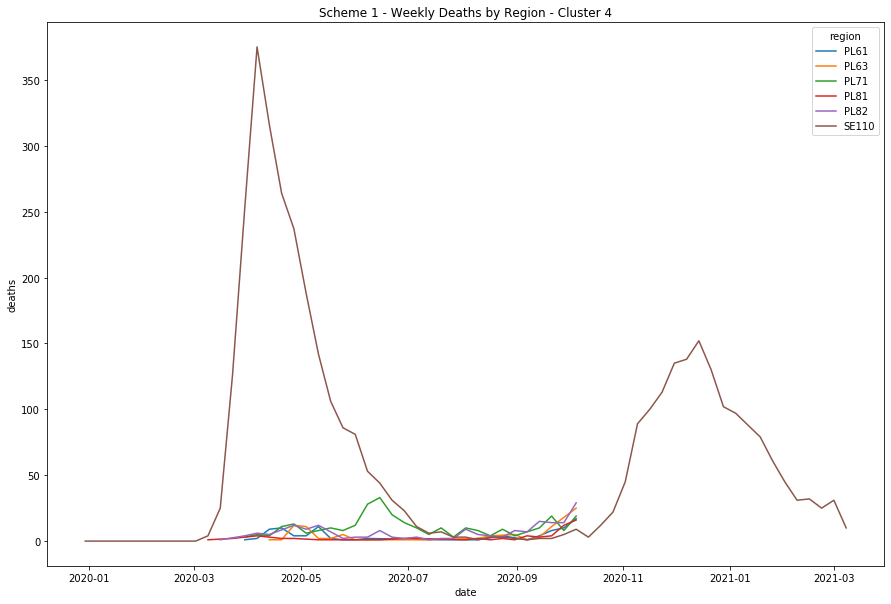

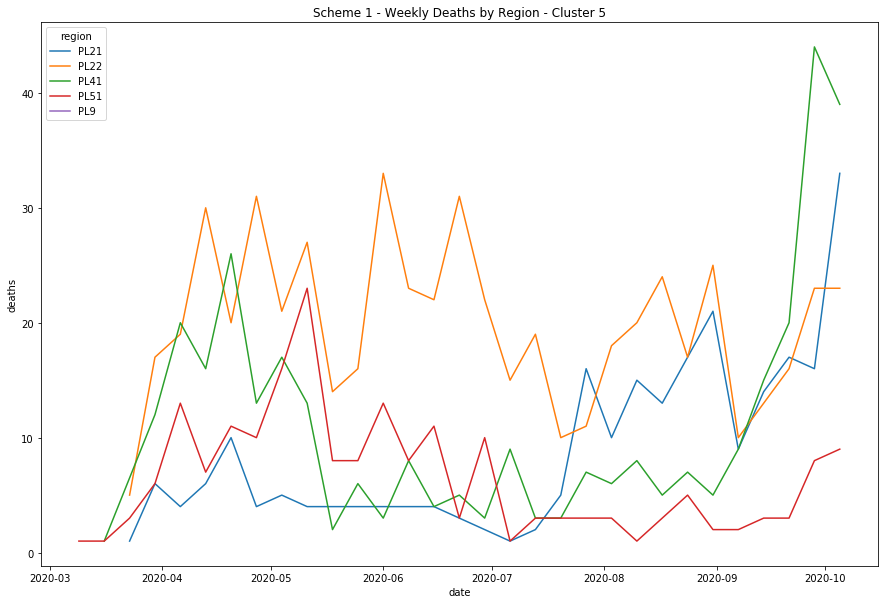

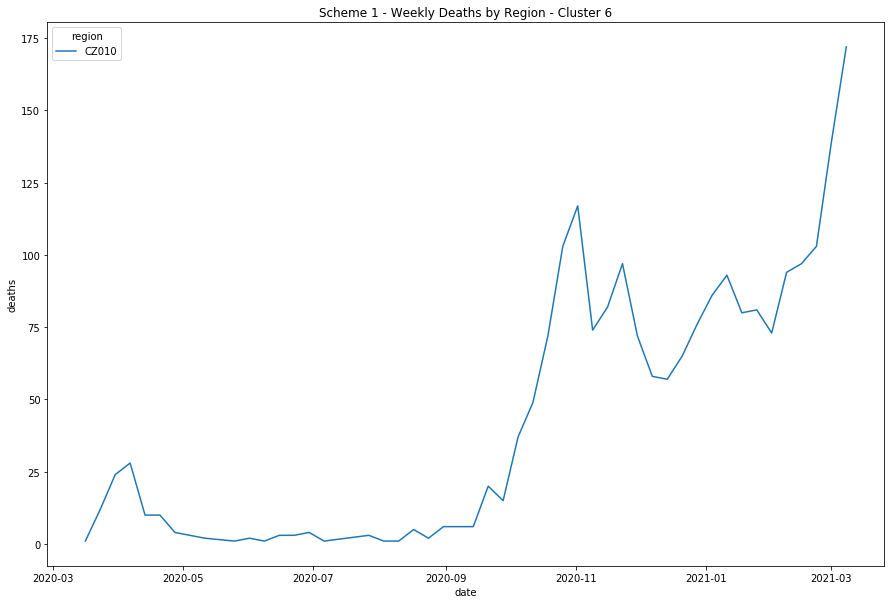

In [7]:
# plot out regional death data by cluster - scheme 1
plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Weekly Deaths by Region - Cluster 1")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_1"] == 1],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Weekly Deaths by Region - Cluster 2")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_1"] == 2],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Weekly Deaths by Region - Cluster 3")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_1"] == 3],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Weekly Deaths by Region - Cluster 4")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_1"] == 4],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Weekly Deaths by Region - Cluster 5")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_1"] == 5],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Weekly Deaths by Region - Cluster 6")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_1"] == 6],
             x="date", y="deaths", hue="region")

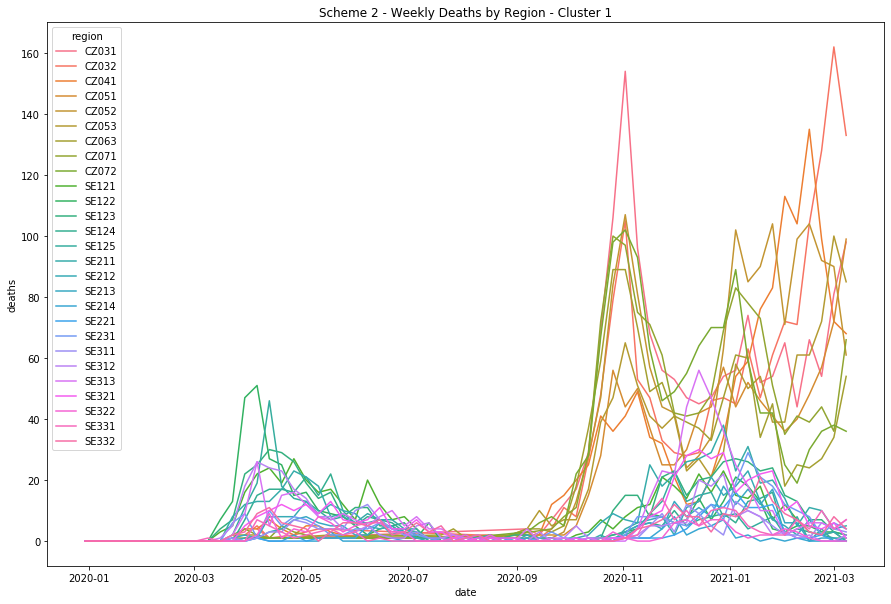

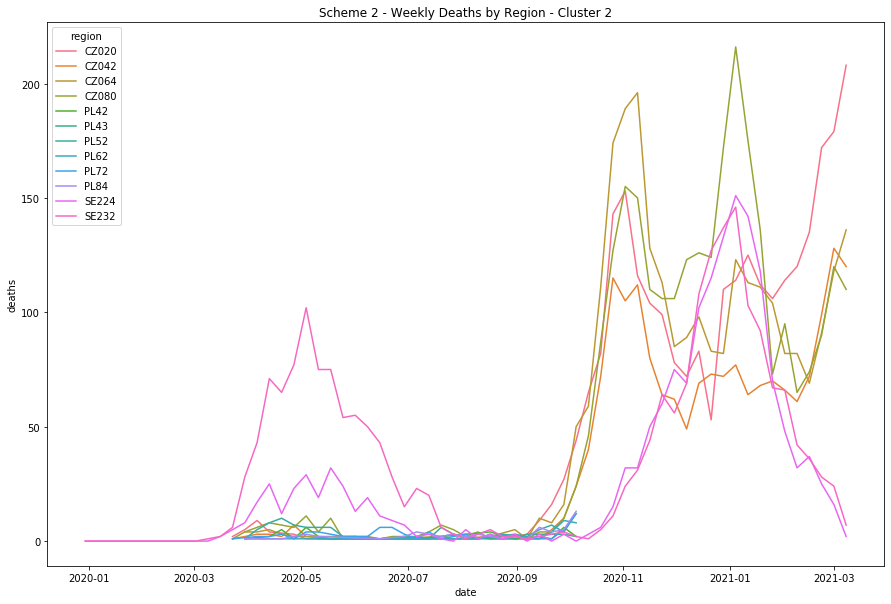

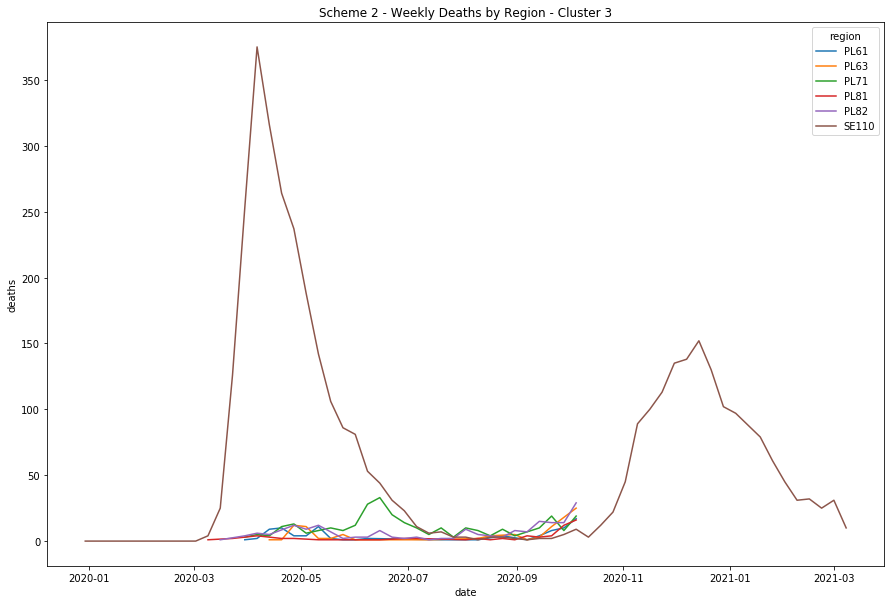

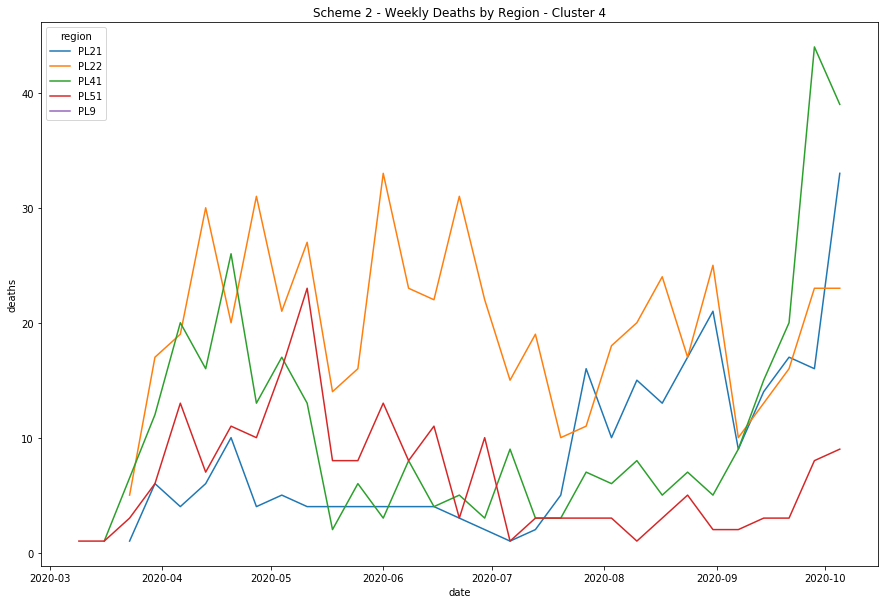

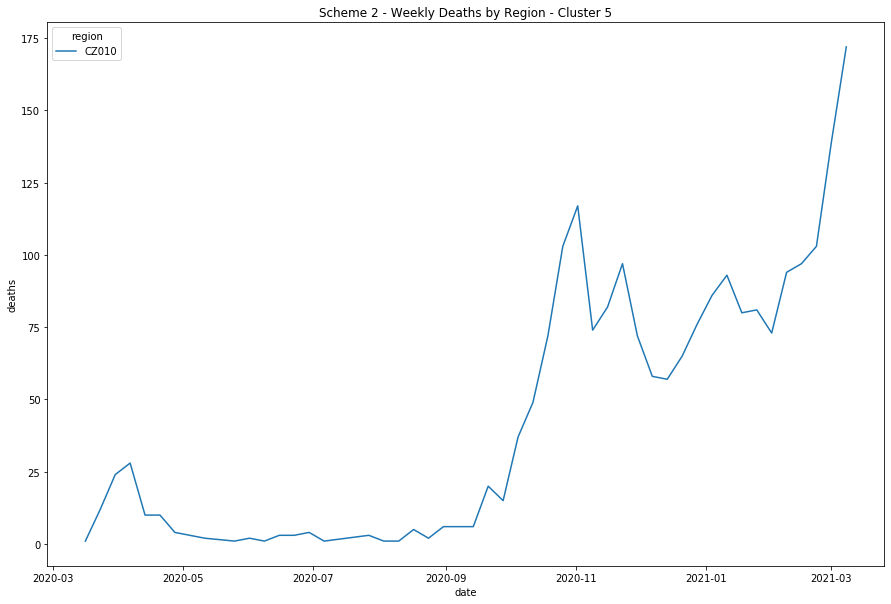

In [8]:
# plot out regional death data by cluster - scheme 2

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Weekly Deaths by Region - Cluster 1")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_2"] == 1],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Weekly Deaths by Region - Cluster 2")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_2"] == 2],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Weekly Deaths by Region - Cluster 3")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_2"] == 3],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Weekly Deaths by Region - Cluster 4")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_2"] == 4],
             x="date", y="deaths", hue="region")

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Weekly Deaths by Region - Cluster 5")
sns.lineplot(data=weekly_deaths_by_region[weekly_deaths_by_region["cluster_2"] == 5],
             x="date", y="deaths", hue="region")

### 3. Aggregated Trends (Mean) by Cluster

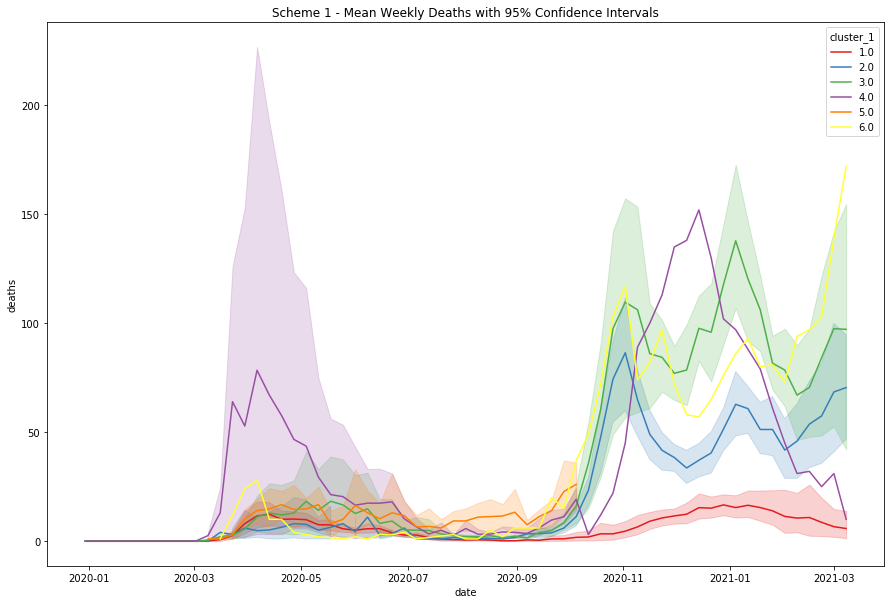

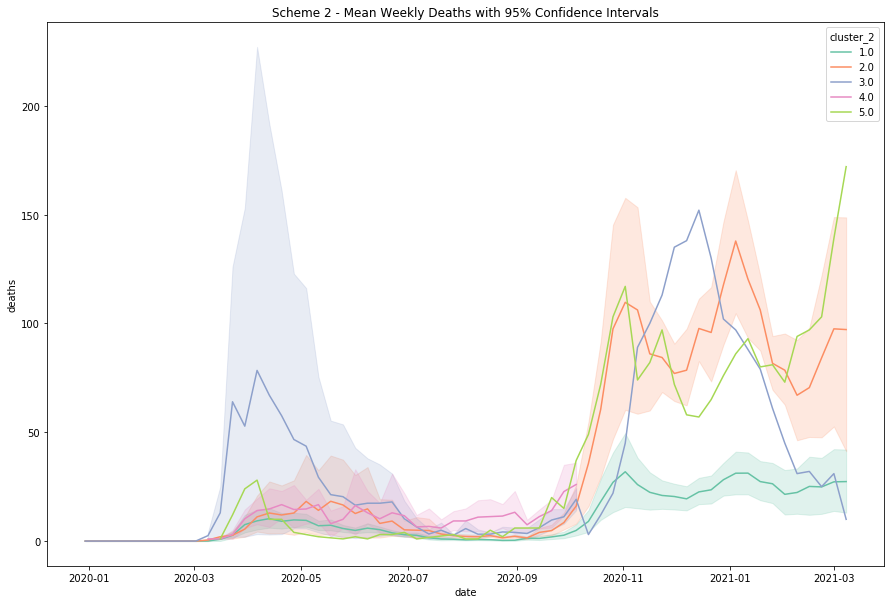

In [9]:
# plot out mean deaths with confidence intervals by cluster

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Mean Weekly Deaths with 95% Confidence Intervals")
sns.lineplot(data=weekly_deaths_by_region, x="date", y="deaths", hue="cluster_1",
            palette=sns.color_palette("Set1", 6)) # 6 = number of clusters

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Mean Weekly Deaths with 95% Confidence Intervals")
sns.lineplot(data=weekly_deaths_by_region, x="date", y="deaths", hue="cluster_2",
            palette=sns.color_palette("Set2", 5)) # 5 = number of clusters

### 4. Aggregated Trends (Median) by Cluster

In [10]:
# median weekly deaths by cluster
scheme1_cluster_by_region_med = \
weekly_deaths_by_region.groupby(['year', 'date', 'week', 'cluster_1']) \
.aggregate({'deaths':'median'}).reset_index()

scheme2_cluster_by_region_med = \
weekly_deaths_by_region.groupby(['year', 'date', 'week', 'cluster_2']) \
.aggregate({'deaths':'median'}).reset_index()

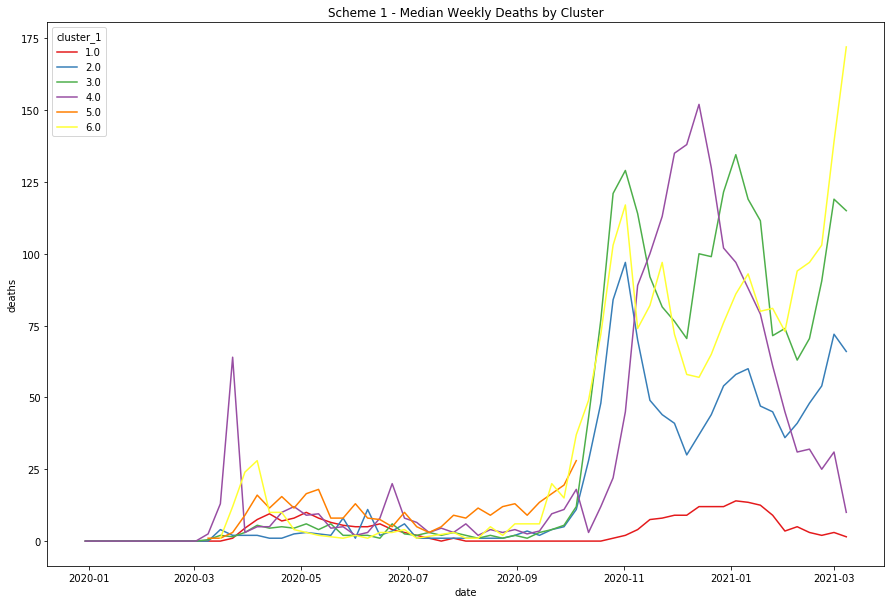

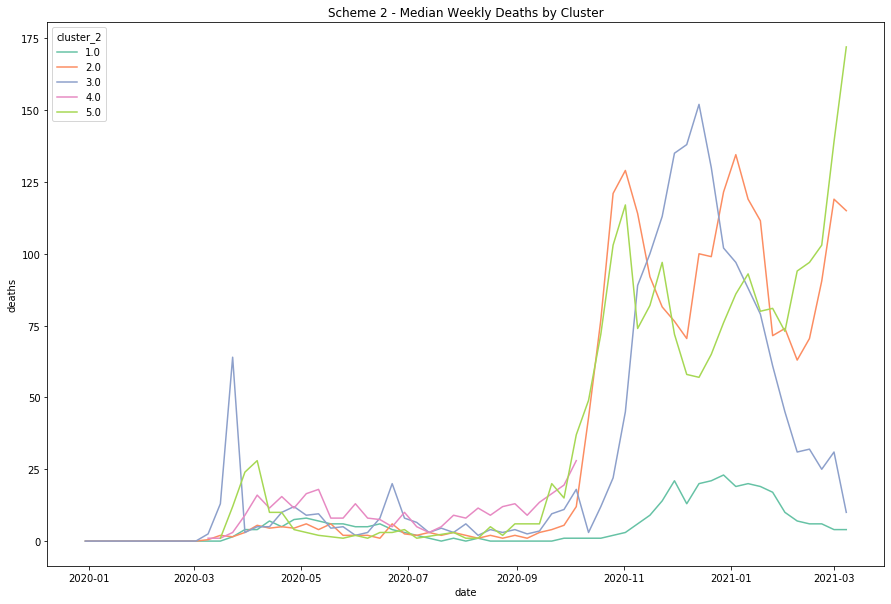

In [11]:
# plot out median deaths by cluster

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - Median Weekly Deaths by Cluster")
sns.lineplot(data=scheme1_cluster_by_region_med, x="date", y="deaths", hue="cluster_1",
            palette=sns.color_palette("Set1", 6)) # 6 = number of clusters

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - Median Weekly Deaths by Cluster")
sns.lineplot(data=scheme2_cluster_by_region_med, x="date", y="deaths", hue="cluster_2",
            palette=sns.color_palette("Set2", 5)) # 6 = number of clusters

### 5. Aggregated Trends (25th Pctl) by Cluster

In [12]:
# 25th pctl weekly deaths by cluster
scheme1_cluster_by_region_25pt = \
weekly_deaths_by_region.groupby(['year', 'date', 'week', 'cluster_1']) \
.deaths.quantile(0.25).reset_index()

scheme2_cluster_by_region_25pt = \
weekly_deaths_by_region.groupby(['year', 'date', 'week', 'cluster_2']) \
.deaths.quantile(0.25).reset_index()

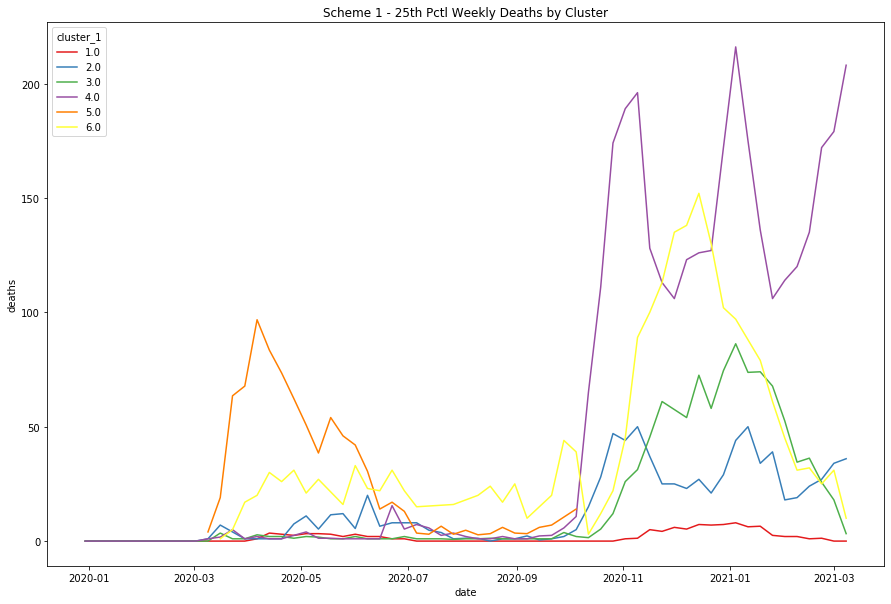

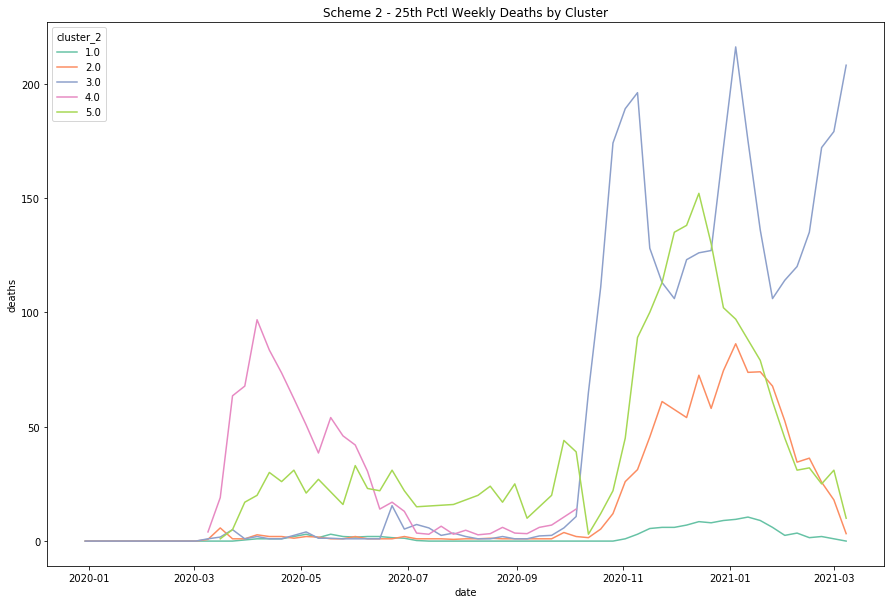

In [13]:
# plot out 25th pctl deaths by cluster

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - 25th Pctl Weekly Deaths by Cluster")
sns.lineplot(data=scheme1_cluster_by_region_25pt, x="date", y="deaths", hue="cluster_1",
            palette=sns.color_palette("Set1", 6)) # 6 = number of clusters

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - 25th Pctl Weekly Deaths by Cluster")
sns.lineplot(data=scheme2_cluster_by_region_25pt, x="date", y="deaths", hue="cluster_2",
            palette=sns.color_palette("Set2", 5)) # 6 = number of clusters

### 7. Aggregated Trends (75th Pctl) by Cluster

In [14]:
# 75th pctl weekly deaths by cluster
scheme1_cluster_by_region_75pt = \
weekly_deaths_by_region.groupby(['year', 'date', 'week', 'cluster_1']) \
.deaths.quantile(0.75).reset_index()

scheme2_cluster_by_region_75pt = \
weekly_deaths_by_region.groupby(['year', 'date', 'week', 'cluster_2']) \
.deaths.quantile(0.75).reset_index()

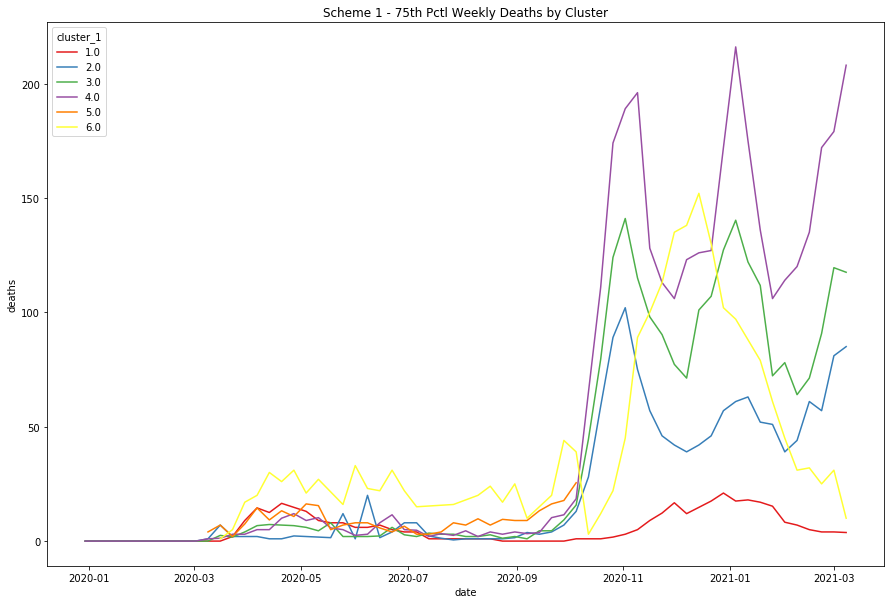

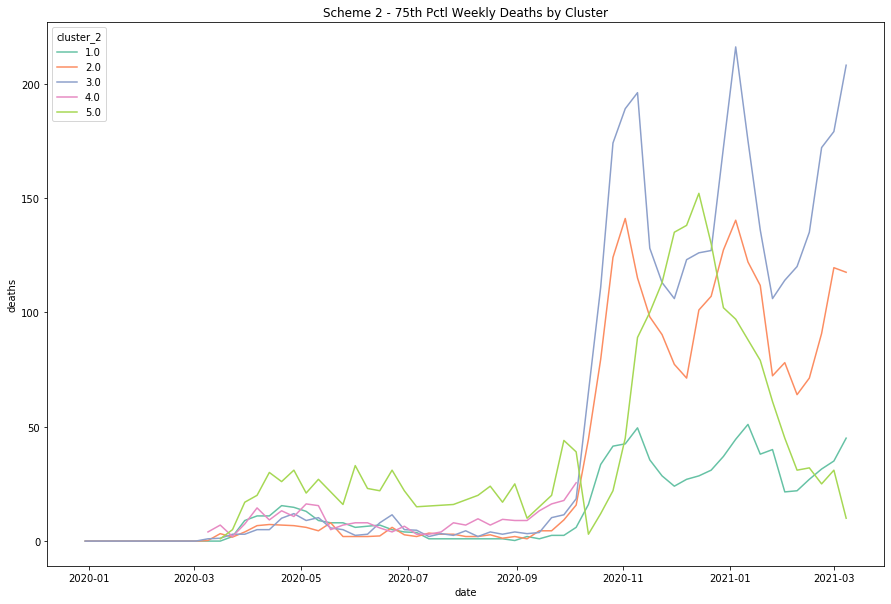

In [15]:
# plot out 25th pctl deaths by cluster

plt.figure(figsize = [15,10])
plt.title("Scheme 1 - 75th Pctl Weekly Deaths by Cluster")
sns.lineplot(data=scheme1_cluster_by_region_75pt, x="date", y="deaths", hue="cluster_1",
            palette=sns.color_palette("Set1", 6)) # 6 = number of clusters

plt.figure(figsize = [15,10])
plt.title("Scheme 2 - 75th Pctl Weekly Deaths by Cluster")
sns.lineplot(data=scheme2_cluster_by_region_75pt, x="date", y="deaths", hue="cluster_2",
            palette=sns.color_palette("Set2", 5)) # 6 = number of clusters